In [3]:
import pandas as pd
import os
from pathlib import Path
import itertools

In [15]:
# Variables for preprocess
num_chunks = 10
num_permutations = 5
dataset_ratio = [0.6, 0.2, 0.2] # Train

In [16]:
# Specify the output directory and input file
output_dir = '../data/processed'
input_file = '../data/raw/diabetes_dataset.csv'

# Make sure the directory exists
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Read the dataset
df = pd.read_csv(input_file)
total_rows = len(df)
print(f'Total rows: {total_rows}')

# Divide into chunks
chunk_size = total_rows // num_chunks
chunks = []
print(f'Chunk size: {chunk_size}')

for i in range(num_chunks):
    chunk = df.iloc[i * chunk_size:(i + 1) * chunk_size]
    chunks.append(chunk)
    print(f"Chunk {i+1}: {len(chunk)} rows")

Total rows: 100000
Chunk size: 10000
Chunk 1: 10000 rows
Chunk 2: 10000 rows
Chunk 3: 10000 rows
Chunk 4: 10000 rows
Chunk 5: 10000 rows
Chunk 6: 10000 rows
Chunk 7: 10000 rows
Chunk 8: 10000 rows
Chunk 9: 10000 rows
Chunk 10: 10000 rows


Total possible permutations: 3628800
Generating 5 random permutations...


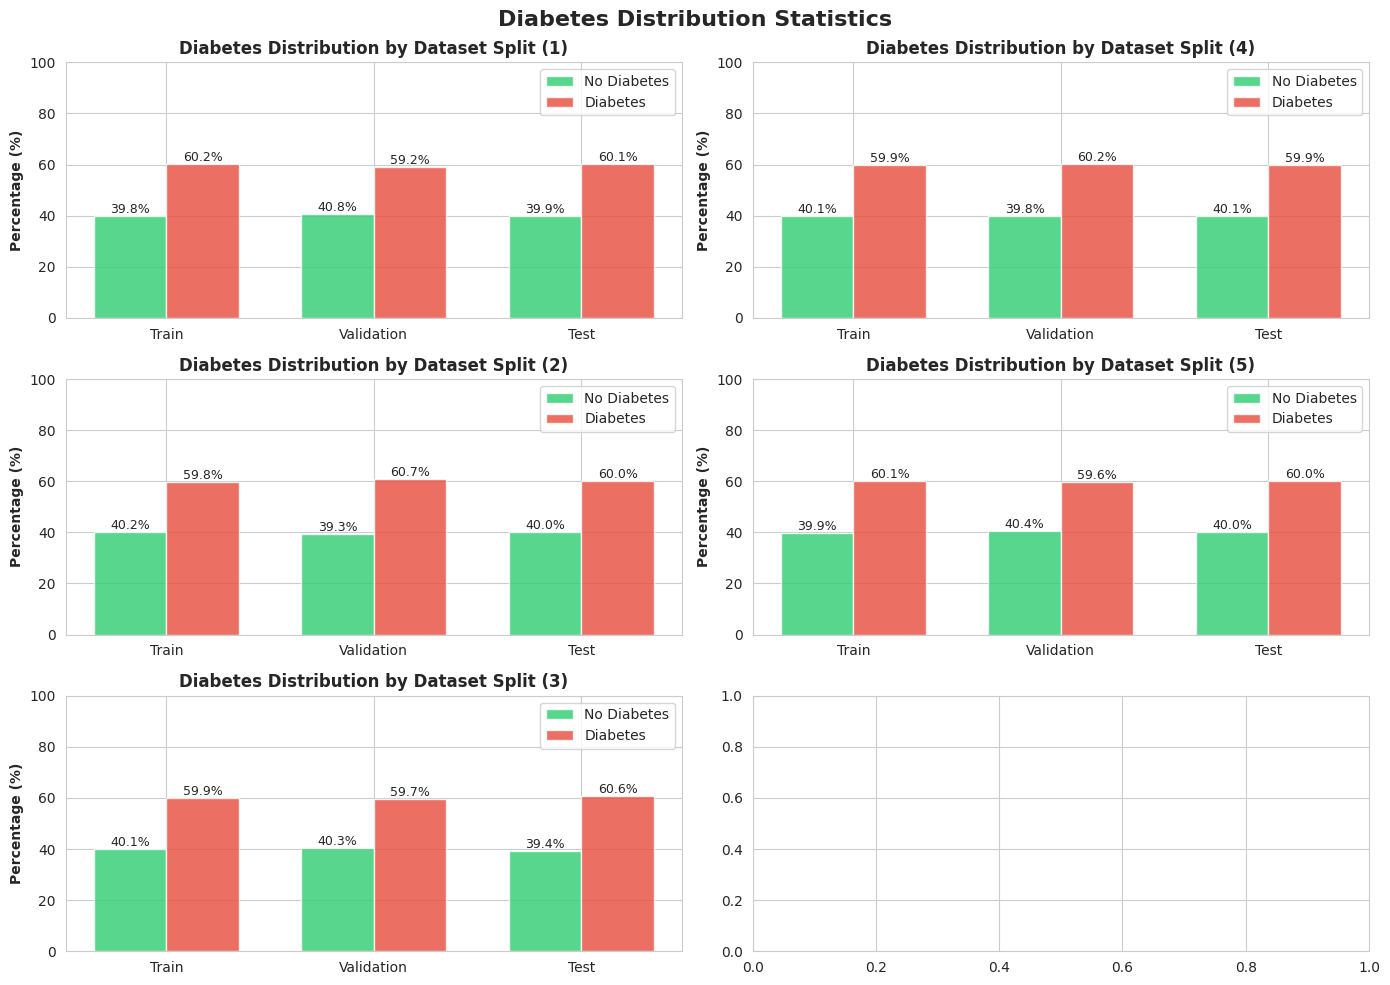

In [39]:
# Create the permutations
indices = list(range(10))
all_permutations = list(itertools.permutations(indices))
total_possible = len(all_permutations)
print(f"Total possible permutations: {total_possible}")

if num_permutations and num_permutations < total_possible:
    import random
    all_permutations = random.sample(all_permutations, num_permutations)
    print(f"Generating {num_permutations} random permutations...")
else:
    print(f"Generating all {total_possible} permutations...")

# Plot settings
# Set style
sns.set_style("whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Diabetes Distribution Statistics', fontsize=16, fontweight='bold')

perms = []

# Create permuted datasets
for idx, perm in enumerate(all_permutations, 1):
    
    # Concatenate chunks in the permuted order
    permuted_df = pd.concat([chunks[i] for i in perm], ignore_index=True)
    perms.append(permuted_df)

    # Split the permutations
    total = len(permuted_df)
    train_size = int(total * dataset_ratio[0])
    val_size = int(total * dataset_ratio[1])
    test_size = int(total * dataset_ratio[2])
    #print(f'')

    train_df = permuted_df.iloc[:train_size]
    val_df = permuted_df.iloc[train_size:train_size + val_size]
    test_df = permuted_df.iloc[train_size + val_size:]

    # Create folder for this permutation
    perm_folder = os.path.join(output_dir, f'permutation_{idx:06d}')
    Path(perm_folder).mkdir(parents=True, exist_ok=True)
    
    # Save the three files
    train_df.to_csv(os.path.join(perm_folder, 'train.csv'), index=False)
    val_df.to_csv(os.path.join(perm_folder, 'validation.csv'), index=False)
    test_df.to_csv(os.path.join(perm_folder, 'test.csv'), index=False)

    if (idx>3):
        ax1 = axes[idx-4, 1]
    else:
        ax1 = axes[idx-1, 0]

    # Plot statistics for the partitioned datasets
    datasets = {
        'Train': train_df,
        'Validation': val_df,
        'Test': test_df
    }

    # Calculate percentages for each dataset
    stats = {}
    for name, df in datasets.items():
        if target_column in df.columns:
            counts = df[target_column].value_counts()
            total = len(df)
            stats[name] = {
                'No Diabetes': (counts.get(0, 0) / total * 100) if total > 0 else 0,
                'Diabetes': (counts.get(1, 0) / total * 100) if total > 0 else 0,
                'Total': total
            }
        else:
            stats[name] = {'No Diabetes': 0, 'Diabetes': 0, 'Total': 0}
            
    # Plot 1: Bar chart comparing percentages across datasets
    x = np.arange(len(datasets))
    width = 0.35
    
    no_diabetes = [stats[name]['No Diabetes'] for name in datasets.keys()]
    diabetes = [stats[name]['Diabetes'] for name in datasets.keys()]
    
    bars1 = ax1.bar(x - width/2, no_diabetes, width, label='No Diabetes', color='#2ecc71', alpha=0.8)
    bars2 = ax1.bar(x + width/2, diabetes, width, label='Diabetes', color='#e74c3c', alpha=0.8)
    
    ax1.set_ylabel('Percentage (%)', fontweight='bold')
    ax1.set_title(f'Diabetes Distribution by Dataset Split ({idx})', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets.keys())
    ax1.legend()
    ax1.set_ylim(0, 100)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()